In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random
import numpy as np
import datetime

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import linear_model
# from imblearn.combine import SMOTETomek

import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders', 'laundry_distance', 'laundry_within_1km']], on='customer_db_id', how='inner')

df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord.pickup_timeslot_from_datetime = pd.to_datetime(df_ord.pickup_timeslot_from_datetime)
df_ord.pickup_timeslot_to_datetime = pd.to_datetime(df_ord.pickup_timeslot_to_datetime)

df_ord['pickup_timeslot_from'] = df_ord.pickup_timeslot_from_datetime.dt.hour
df_ord['pickup_timeslot_to'] = df_ord.pickup_timeslot_to_datetime.dt.hour

df_ord.loc[df_ord.corporate, 'service_class'] = 'CORP'
df_ord['service_class_paid'] = False
df_ord.loc[df_ord.service_class.isin(['EXPRESS', 'PLUS']), 'service_class_paid'] = True

df_ord.voucher_revenue_ratio = df_ord.voucher_revenue_ratio.round(1)

In [4]:
# df_items = pd.read_csv('../data/input/items.csv')
# df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_type': 'nunique'}).reset_index()
# df_items = df_items.rename(columns={'product_type': 'num_unique_products'})
# df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [5]:
df_items = pd.read_csv('../data/input/items.csv')[['order_id', 'product_group', 'quantity']]
df_items = df_items.groupby(['order_id', 'product_group']).max().unstack().fillna(0)
df_items.columns = ['prod_' + c for c in df_items.columns.get_level_values(1)]
df_items = pd.DataFrame(df_items.to_records())
df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [6]:
df_clusters = pd.read_csv('../data/input/item_clusters_cities.csv')
# df_clusters['cluster'] = df_clusters.cluster.apply(lambda x: int(x[-1])).astype(int)
df_ord = df_ord.drop(['cluster'], axis=1).merge(df_clusters, on='order_id', how='left')

In [7]:
# df_ord = df_ord.join(pd.get_dummies(df_ord['cluster_city'], prefix='cluster'))
# df_ord = df_ord.join(pd.get_dummies(df_ord['service_class'], prefix='service'))

In [8]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,cluster
0,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
1,DE-B-20696,5a1ee6e144770903118b466f,5abe2737467709f94e8b4695,52.491111,13.429692,2018-04-04 06:00:00,2018-04-04 07:00:00,12047,completed,2018-03-30 14:01:59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,B_1
2,DE-B-72139,5a1ee6e144770903118b466f,5b8a56d5ee1b6a373e38f39c,52.491111,13.429692,2018-09-03 10:00:00,2018-09-03 11:00:00,12047,completed,2018-09-01 11:07:33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
3,DE-B-87918,5a1ee6e144770903118b466f,5afc6c33c3436275d6724815,52.491111,13.429692,2018-05-22 07:00:00,2018-05-22 08:00:00,12047,completed,2018-05-16 19:36:51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,B_1
4,DE-C-27253,5a1ee6e144770903118b466f,5b20cb79ee1b6a090e115c25,52.491111,13.429692,2018-06-16 12:00:00,2018-06-16 13:00:00,12047,completed,2018-06-13 09:44:57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1


# Create Dataset

In [9]:
num_orders = 1
churn_days = 90
# city = 'London'

In [10]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & ~(df_ord.corporate) & (df_ord.city == 'London')]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount() + 1

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['last_order_comp'] = pd.to_datetime(df_comp.groupby('customer_db_id')['order_created_datetime'].transform('max'))
df_comp['recency_comp'] = (datetime.datetime.now() - df_comp.last_order_comp).dt.days

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [11]:
# create featrues
# frequency
df_comp['frequency_median_exp'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(
                                                    lambda x: x.expanding().median()).fillna(-999)
# revenue
df_comp['revenue_brutto'] = (df_comp.revenue + df_comp.voucher_value).fillna(0)
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = (df_comp.revenue_brutto - df_comp.last_order_revenue_brutto).fillna(-999)

# cluster
df_comp['last_order_cluster'] = df_comp.groupby(['customer_db_id'])['cluster'].shift(1)
df_comp['cluster_changed'] = df_comp.cluster == df_comp.last_order_cluster

# completed ratio
df_comp['completed_orders_ratio'] = (df_comp['order_comp_num'] / df_comp['order_num']).round(1)

df_comp['churn_days'] = df_comp.days_until_next_comp.fillna(df_comp.recency_comp)
df_comp['churned'] = [1 if x > churn_days else 0 for x in df_comp.churn_days]

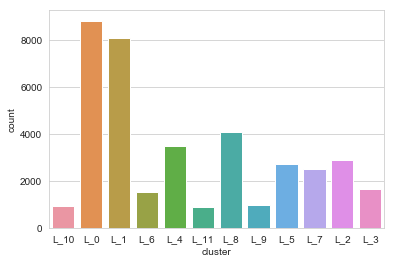

In [12]:
sns.categorical.countplot(df_comp.cluster)

In [13]:
df_comp.churned.value_counts()

0    25579
1    12978
Name: churned, dtype: int64

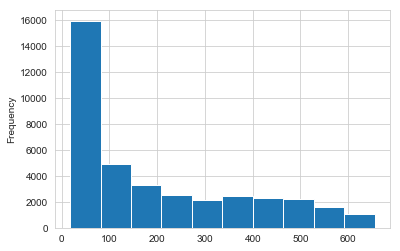

In [14]:
df_comp.recency_comp.plot(kind='hist')

In [15]:
df_comp.to_csv('../data/old/comp_orders.csv', index=False)

# Fill NAs

In [16]:
nans = df_comp.isnull().sum()
nans[nans > 0].sort_values(ascending=False)

refund_approved              38005
refund_request               38005
refund_type                  38005
refund_liability             38005
rating_cleaning_quality      36560
rating_damaged_item          36560
rating_driver_conduct        36560
rating_ironing_quality       36560
rating_missing_items         36560
rating_punctuality           36560
num_internal_reschedules     34758
internal_rescheduled         34758
num_customer_reschedules     34758
customer_rescheduled         34758
voucher_channel              27532
rating                       19161
last_order_cluster           14625
days_until_next_comp         14622
last_order_revenue_brutto    14622
days_since_last_comp         14622
days_until_next_order        14131
days_since_last_order        13437
product_combinations          5913
product_type                  5913
laundry_distance              1683
laundry_within_1km            1683
fac_name                       912
reclean_order                  912
gender              

In [17]:
df_comp.select_dtypes(include='object').columns

Index(['order_id', 'customer_db_id', 'order_db_id', 'pickup_zip',
       'order_state', 'service_class', 'software_type', 'origin', 'city',
       'voucher_channel', 'final_click_channel', 'final_click_no_voucher',
       'gender', 'product_type', 'segment', 'activity_state', 'last_order',
       'fac_name', 'reclean_order', 'customer_rescheduled',
       'internal_rescheduled', 'driver_db_id_DO', 'driver_db_id_PU',
       'punctual_5min_DO', 'punctual_5min_PU', 'punctual_order',
       'refund_liability', 'refund_type', 'refund_request', 'refund_approved',
       'product_combinations', 'customer_id', 'email', 'cluster_name',
       'cluster', 'last_order_cluster'],
      dtype='object')

In [18]:
str_to_bool = ['reclean_order', 'punctual_5min_DO', 'punctual_5min_PU', 'punctual_order',
               'refund_request', 'refund_approved']
for c in str_to_bool:
    df_comp[c] = df_comp[c].fillna(False).astype('bool')

In [19]:
str_cols = df_comp.select_dtypes(include='object').columns
num_cols = df_comp.select_dtypes(include='number').columns
bool_cols = df_comp.select_dtypes(include='bool').columns

In [20]:
df_comp[str_cols] = df_comp[str_cols].fillna('unknown')
df_comp['rating'] = df_comp.rating.fillna(-999)
df_comp.num_customer_reschedules = df_comp.num_customer_reschedules.fillna(0)
df_comp.num_internal_reschedules = df_comp.num_internal_reschedules.fillna(0)
df_comp[num_cols] = df_comp[num_cols].fillna(-999)
df_comp[bool_cols] = df_comp[bool_cols].fillna(False)

In [21]:
# df_last = df_comp.loc[(df_comp.order_comp_num == num_orders)] # & (df_ord.city == city)]
df_last = df_comp.loc[df_comp.order_comp_num > 1]

In [22]:
# df_unknown = df_last.loc[(df_last.completed_orders == num_orders) & (df_last.recency_comp < churn_days)]
# df_known = df_last[~df_last.index.isin(df_unknown.index)]

In [23]:
df_unknown = df_last.loc[df_last.recency_comp < churn_days]
df_known = df_last[~df_last.index.isin(df_unknown.index)]

In [24]:
df_known.churned.value_counts()

0    7140
1    4041
Name: churned, dtype: int64

In [25]:
df_known_1 = df_known.loc[df_known.churned == 1]
df_known_0 = df_known.loc[df_known.churned == 0].sample(len(df_known_1))


df_known = df_known_1.append(df_known_0)
df_known.churned.value_counts()

1    4041
0    4041
Name: churned, dtype: int64

# Features

In [26]:
sorted(df_known.columns.tolist())

['activity_state',
 'aov',
 'churn_days',
 'churn_factor',
 'churned',
 'city',
 'cluster',
 'cluster_changed',
 'cluster_name',
 'completed_orders',
 'completed_orders_ratio',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_comp',
 'days_since_last_order',
 'days_until_next_comp',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'frequency',
 'frequency_median_exp',
 'gender',
 'internal_rescheduled',
 'last_order',
 'last_order_cluster',
 'last_order_comp',
 'last_order_revenue_brutto',
 'last_revenue_brutto_diff',
 'laundry_distance',
 'laundry_within_1km',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'order_comp_num',
 'order_created_datetime',
 'order_db_id',
 'order_id',
 'order_num',
 'order_state',
 'order_x',
 'order_y',
 'origin',
 'pickup_timeslot_from',
 'pickup_timeslot_from_datetime',
 'pickup_timeslot_to',
 'pickup_timeslot_to_datetime',
 'pickup_zip',
 'prod_Accessories',
 'prod_Blazer',
 'prod_Blouse',
 'prod_Coats',
 'prod_Dress',
 'prod_DressSpecial',
 'prod_Household',
 'prod_Knitwear',
 'prod_Others',
 'prod_Shirt',
 'prod_Shorts',
 'prod_Skirt',
 'prod_Skiwear',
 'prod_Suit',
 'prod_Top',
 'prod_Trousers',
 'prod_Tshirt',
 'prod_Underwear',
 'prod_WashFold',
 'product_DC',
 'product_HH',
 'product_LA',
 'product_WF',
 'product_combinations',
 'product_type',
 'punctual_5min_DO',
 'punctual_5min_PU',
 'punctual_order',
 'rating',
 'rating_cleaning_quality',
 'rating_damaged_item',
 'rating_driver_conduct',
 'rating_ironing_quality',
 'rating_missing_items',
 'rating_punctuality',
 'recency',
 'recency_comp',
 'reclean_order',
 'referred',
 'refund_approved',
 'refund_liability',
 'refund_request',
 'refund_type',
 'revenue',
 'revenue_brutto',
 'segment',
 'service_class',
 'service_class_paid',
 'software_type',
 'voucher_channel',
 'voucher_revenue_ratio',
 'voucher_used',
 'voucher_value']

In [27]:
feats = [
    # items
    'cluster', 'laundry_distance', 'laundry_within_1km',
    
    # behaviour
    'service_class_paid', 'voucher_revenue_ratio', 'revenue_brutto',
    'completed_orders_ratio', 'pickup_timeslot_from', 'voucher_channel',
    'voucher_used', 'gender', 'software_type', 'final_click_channel',
    
    # experience
    'num_customer_reschedules', 'num_internal_reschedules', 
    'punctual_order', 'rating', 'reclean_order', 'refund_request',
    'referred']

feats = feats + [c for c in df_known.columns if 'prod_' in c]

pred_name = 'churned'

In [28]:
# Encode
df_enc = df_known[feats]

In [29]:
# df_enc = df_enc.join(pd.get_dummies(df_enc['voucher_channel'], prefix='voucher_channel')).drop(['voucher_channel'], axis=1)
# df_enc = df_enc.join(pd.get_dummies(df_enc['gender'], prefix='gender')).drop(['gender'], axis=1)
# df_enc = df_enc.join(pd.get_dummies(df_enc['software_type'], prefix='software_type')).drop(['software_type'], axis=1)
# df_enc = df_enc.join(pd.get_dummies(df_enc['cluster'], prefix='cluster')).drop(['cluster'], axis=1)

In [30]:
df_enc.select_dtypes(include='object').columns

Index(['cluster', 'voucher_channel', 'gender', 'software_type',
       'final_click_channel'],
      dtype='object')

In [31]:
str_cols = df_enc.select_dtypes(include='object').columns
if len(str_cols) > 0:
    df_enc[str_cols] = df_enc[str_cols].apply(LabelEncoder().fit_transform)

In [32]:
df_enc = df_enc.join(df_known[pred_name])

In [33]:
df_enc.head().T

,73909,61205,61207,62801,73904
cluster,1,3,10,10,6
laundry_distance,1513.45,632.229,632.229,2451.07,962.364
laundry_within_1km,0,1,1,0,1
service_class_paid,True,False,False,False,True
voucher_revenue_ratio,0,0,0,0,0
revenue_brutto,61.5601,62.7374,15.5907,32.4002,32.473
completed_orders_ratio,0.7,1,0.6,1,1
pickup_timeslot_from,10,9,18,9,18
voucher_channel,12,12,12,12,12
voucher_used,False,False,False,False,False


In [34]:
X = df_enc.drop(pred_name, axis=1).values
y = df_enc[pred_name].values
n_classes = df_enc[pred_name].nunique()
print(X.shape, y.shape)
print(n_classes)

(8082, 39) (8082,)
2


In [35]:
X = StandardScaler().fit_transform(X)

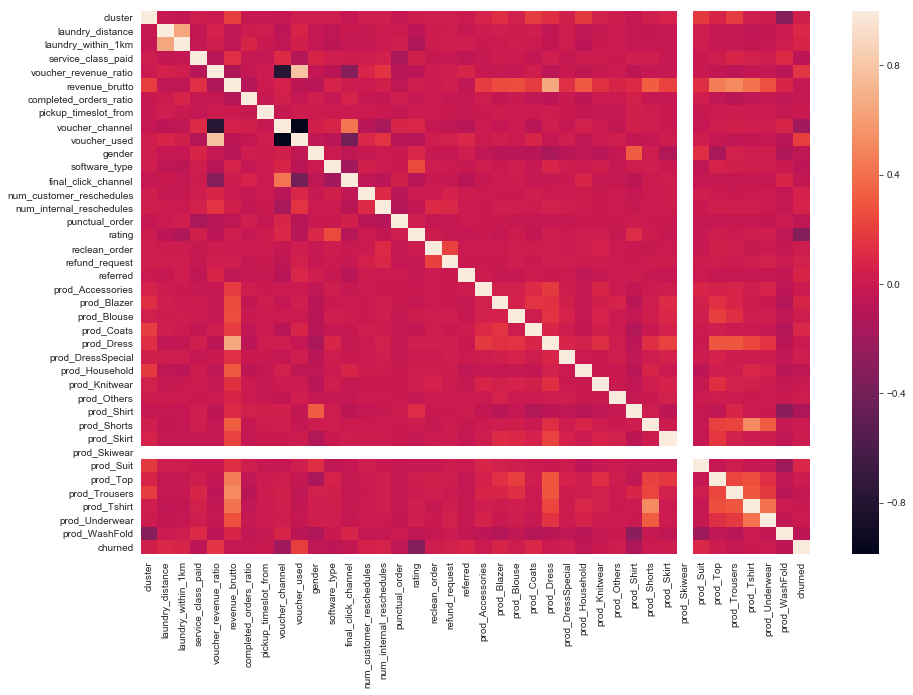

In [36]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_enc.corr(), xticklabels=df_enc.columns, yticklabels=df_enc.columns)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
model_lin = linear_model.LogisticRegression()
model_lin.fit(X_train, y_train)
model_lin.score(X_test, y_test)

0.67738743196437412

In [73]:
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, gamma=5, feature_names=feats)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.758608	validation_1-auc:0.729663
[1]	validation_0-auc:0.761808	validation_1-auc:0.729193
[2]	validation_0-auc:0.769716	validation_1-auc:0.733702
[3]	validation_0-auc:0.773024	validation_1-auc:0.737497
[4]	validation_0-auc:0.775299	validation_1-auc:0.738987
[5]	validation_0-auc:0.776053	validation_1-auc:0.739056
[6]	validation_0-auc:0.777688	validation_1-auc:0.740004
[7]	validation_0-auc:0.780865	validation_1-auc:0.740999
[8]	validation_0-auc:0.781052	validation_1-auc:0.741143
[9]	validation_0-auc:0.783979	validation_1-auc:0.740665
[10]	validation_0-auc:0.787535	validation_1-auc:0.741546
[11]	validation_0-auc:0.788502	validation_1-auc:0.742546
[12]	validation_0-auc:0.791576	validation_1-auc:0.744388
[13]	validation_0-auc:0.792888	validation_1-auc:0.745039
[14]	validation_0-auc:0.793986	validation_1-auc:0.746544
[15]	validation_0-auc:0.795136	validation_1-auc:0.746823
[16]	validation_0-auc:0.795786	validation_1-auc:0.747703
[17]	validation_0-auc:0.79803	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       feature_names=['cluster', 'laundry_distance', 'laundry_within_1km', 'service_class_paid', 'voucher_revenue_ratio', 'revenue_brutto', 'completed_orders_ratio', 'pickup_timeslot_from', 'voucher_channel', 'voucher_used', 'gender', 'software_type', 'final_click_channel', 'num_customer_reschedules', 'num...kiwear', 'prod_Suit', 'prod_Top', 'prod_Trousers', 'prod_Tshirt', 'prod_Underwear', 'prod_WashFold'],
       gamma=5, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [74]:
print("Train ROC-AUC: {0:.2f}%".format(metrics.f1_score(y_train, model.predict(X_train)) * 100))
print("Test ROC-AUC: {0:.2f}%".format(metrics.f1_score(y_test, model.predict(X_test)) * 100))

Train ROC-AUC: 73.96%
Test ROC-AUC: 68.82%


In [75]:
print("Train ROC-AUC: {0:.2f}%".format(metrics.accuracy_score(y_train, model.predict(X_train)) * 100))
print("Test ROC-AUC: {0:.2f}%".format(metrics.accuracy_score(y_test, model.predict(X_test)) * 100))

Train ROC-AUC: 74.28%
Test ROC-AUC: 69.03%


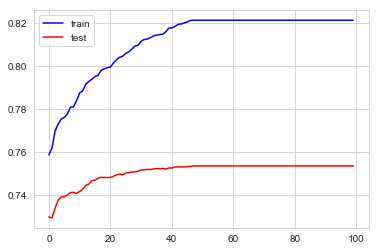

In [76]:
train_loss = model.evals_result()['validation_0']['auc']
test_loss = model.evals_result()['validation_1']['auc']
plt.figure()
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.legend(['train', 'test'])

Text(34,0.5,'True')

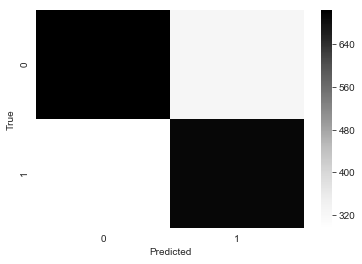

In [43]:
sns.heatmap(metrics.confusion_matrix(y_test, model.predict(X_test)), cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')

In [44]:
fmap = dict(zip(["f"+str(i) for i in range(len(df_enc.columns))],df_enc.columns))

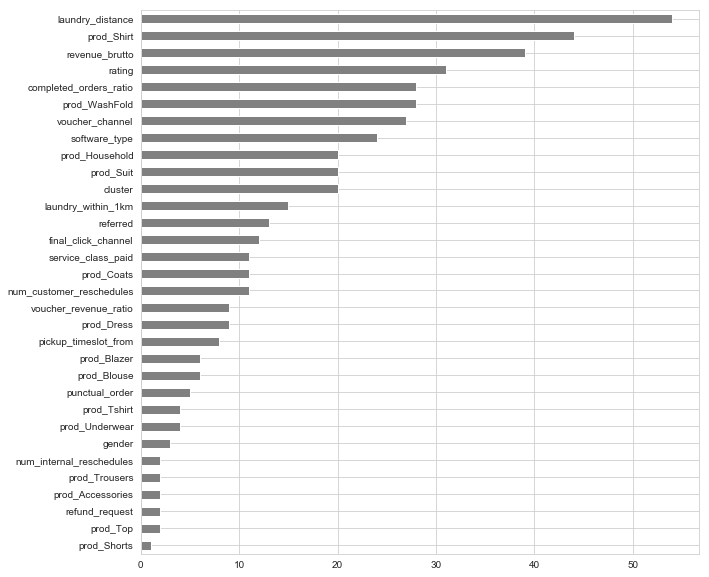

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
df_imp = pd.Series(model.get_booster().get_score()).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')

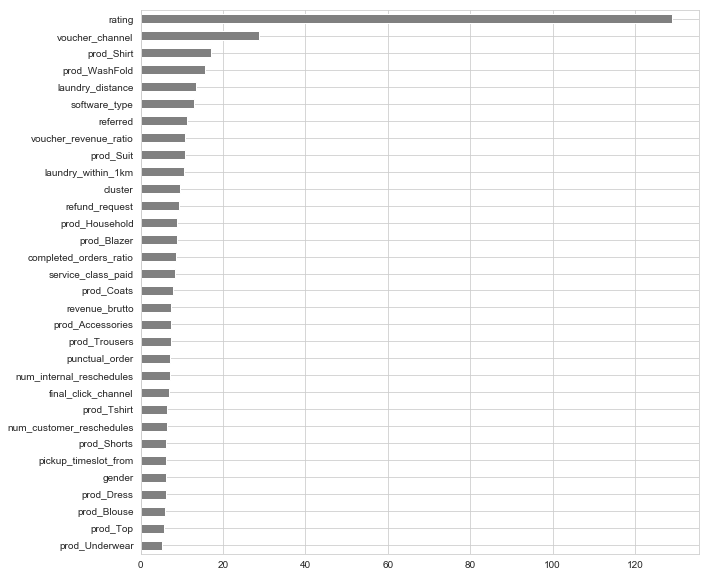

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
df_imp = pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')

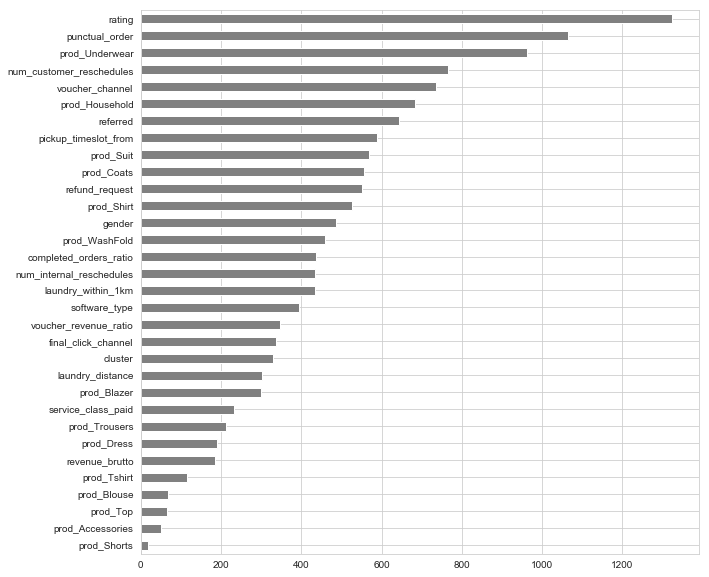

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
df_imp = pd.Series(model.get_booster().get_score(importance_type='cover')).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')

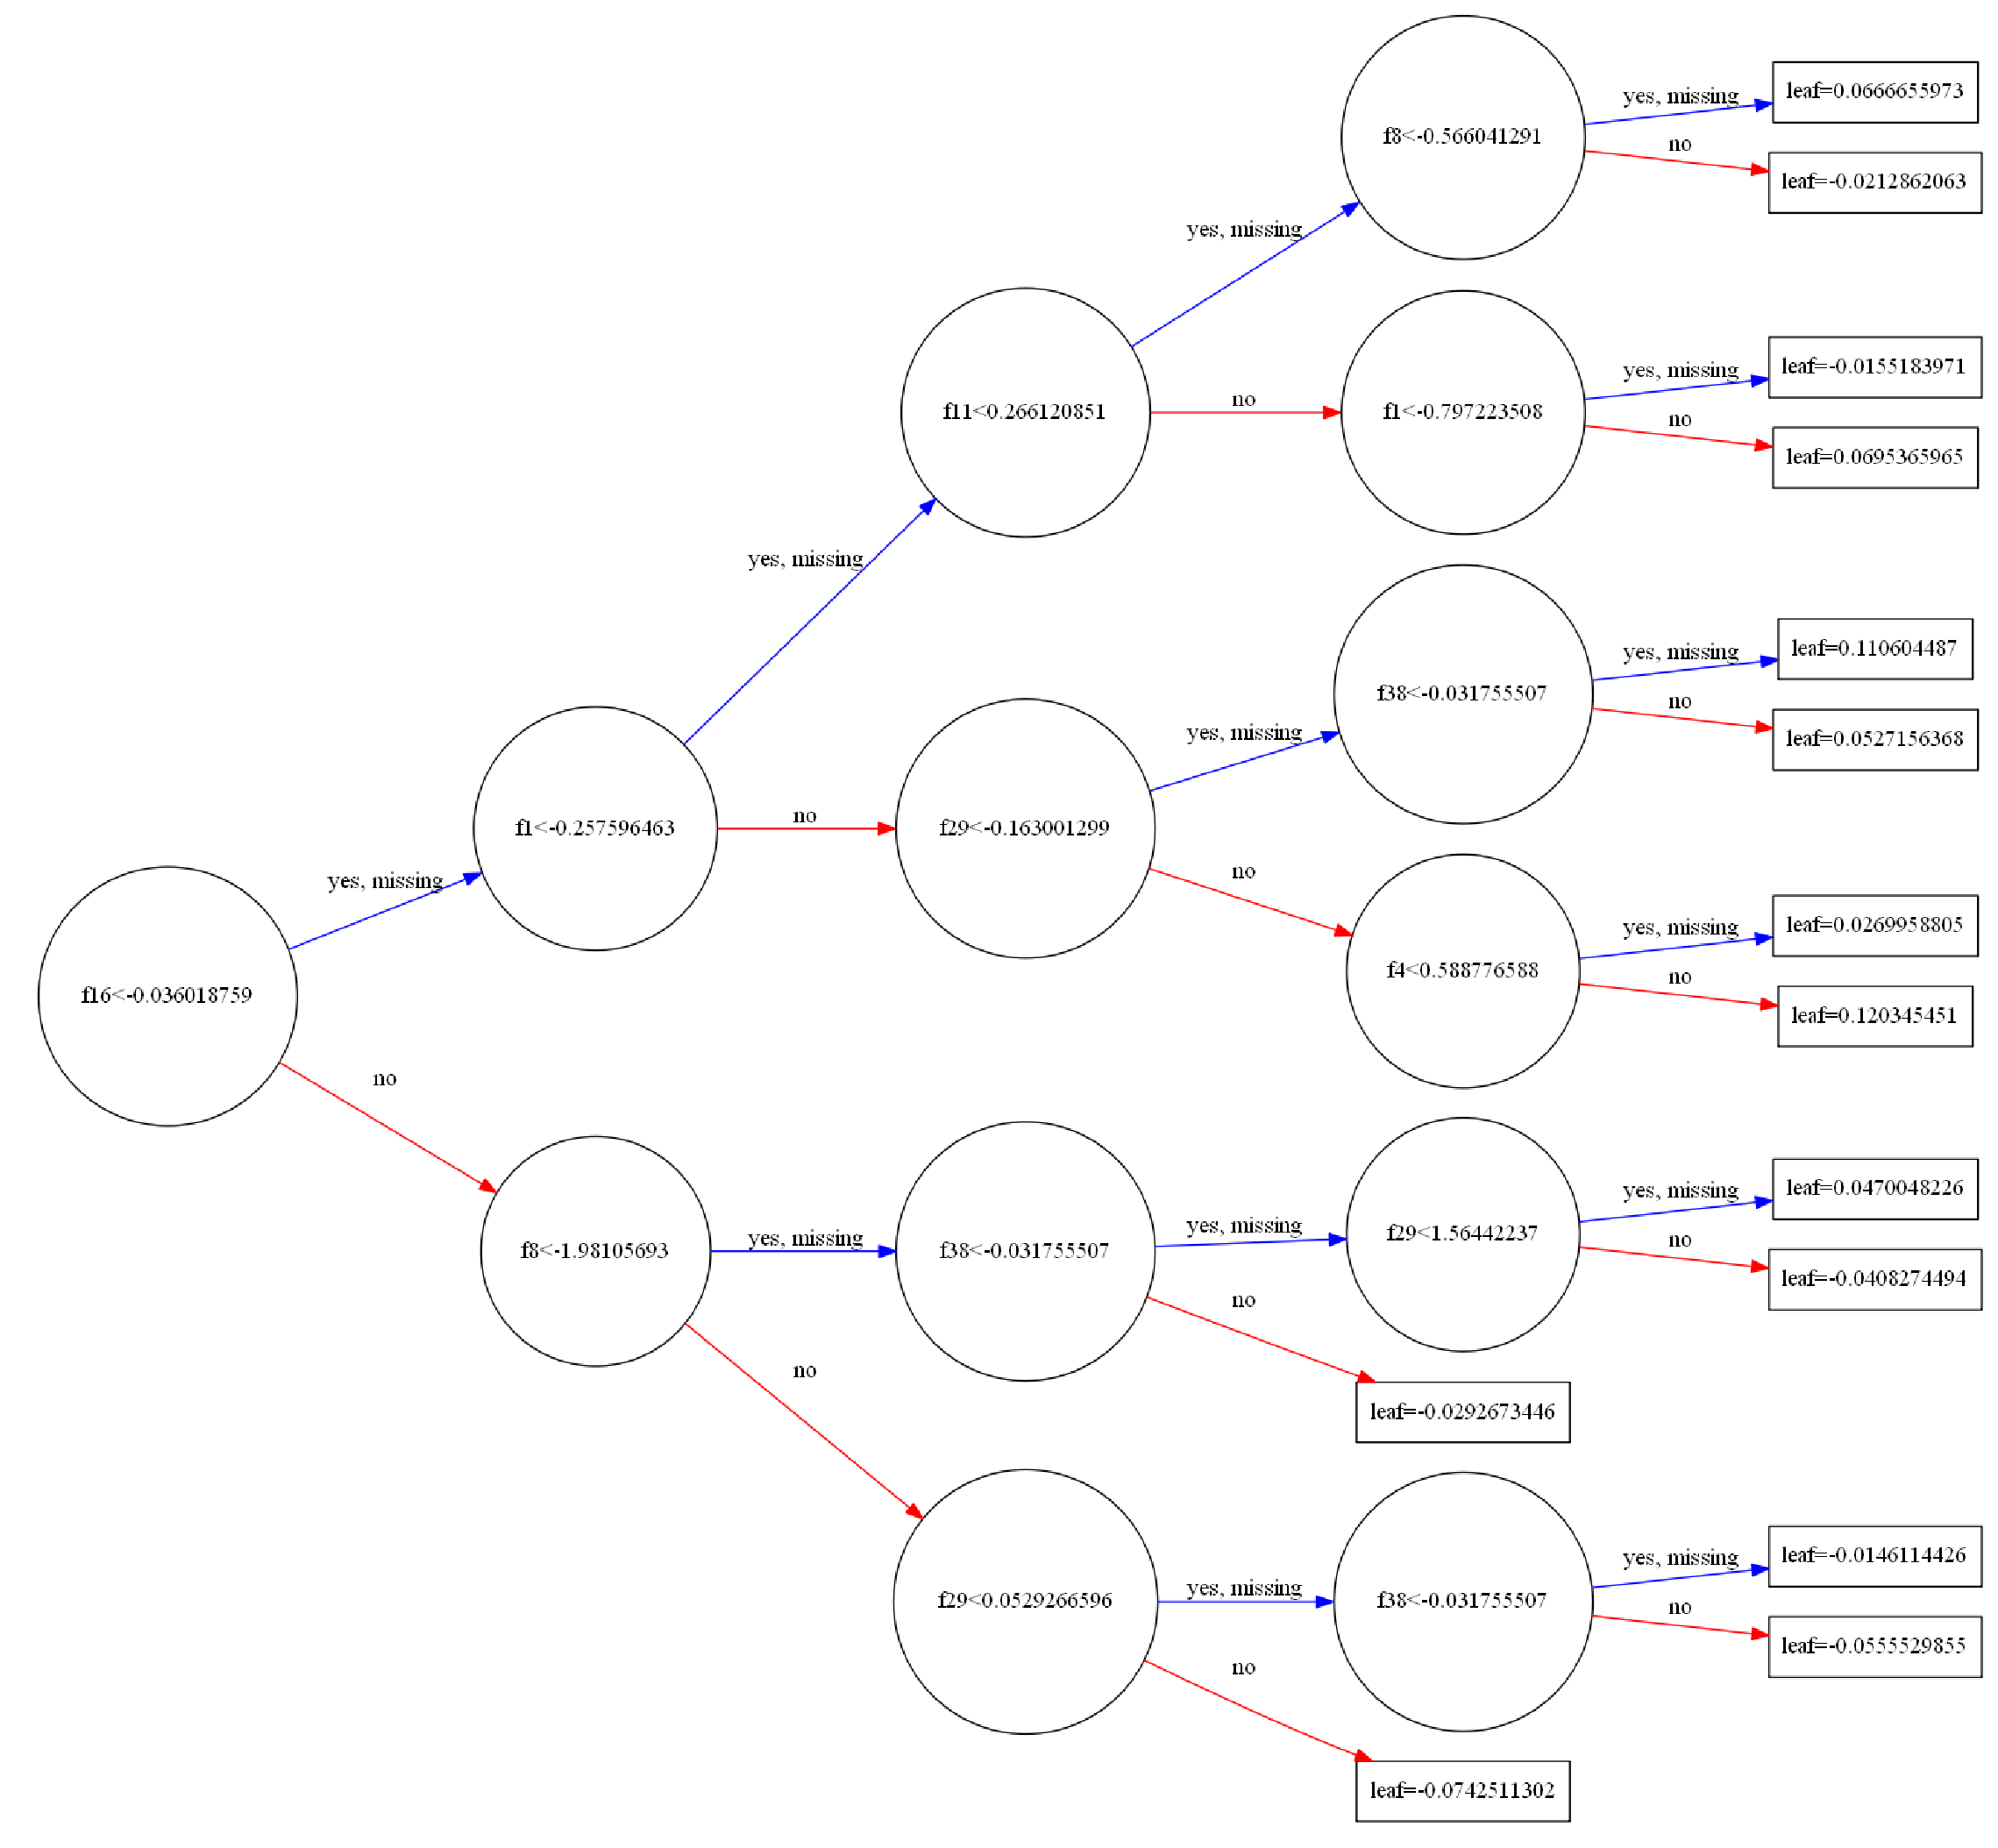

In [48]:
fig, ax = plt.subplots(figsize=(40,40))
xgb.plot_tree(model.get_booster(), ax=ax,rankdir='LR', num_trees=4)

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

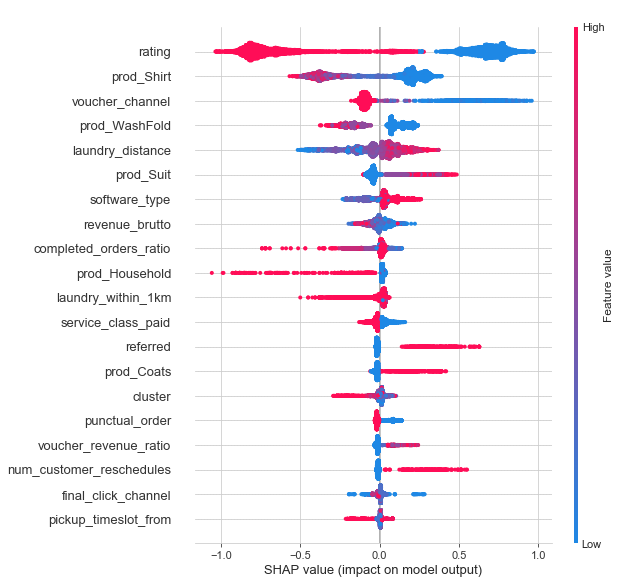

In [50]:
shap.summary_plot(shap_values, X, feature_names=feats)

In [51]:
dict(zip(df_enc.final_click_channel, df_known.final_click_channel))

{7: 'direct',
 11: 'not tracked',
 12: 'other',
 14: 'sem',
 18: 'website',
 6: 'crm-journey',
 15: 'seo',
 4: 'criteo',
 2: 'cc',
 5: 'crm-campaign',
 8: 'facebook',
 0: 'affiliate',
 16: 'social media',
 10: 'internal',
 3: 'cooperations',
 17: 'twitter',
 1: 'apple search',
 13: 'refer a friend',
 9: 'flyering'}

In [52]:
df_known.groupby(['final_click_channel'])['churned'].value_counts() / df_known.order_id.nunique()

final_click_channel  churned
affiliate            0          0.003106
                     1          0.002236
apple search         1          0.001491
                     0          0.000497
cc                   1          0.024720
                     0          0.012547
cooperations         0          0.002484
                     1          0.002484
criteo               0          0.014783
                     1          0.005217
crm-campaign         1          0.044224
                     0          0.013913
crm-journey          1          0.040497
                     0          0.014410
direct               0          0.292919
                     1          0.231429
facebook             0          0.006957
                     1          0.005963
flyering             0          0.000124
                     1          0.000124
internal             0          0.001615
                     1          0.000497
not tracked          1          0.022112
                     0      

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

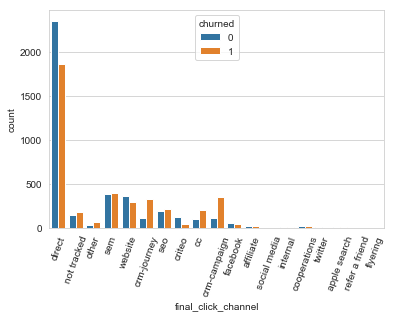

In [53]:
fig, ax = plt.subplots()
sns.countplot(data=df_known, x='final_click_channel', hue='churned', ax=ax)
plt.xticks(rotation=70)

In [54]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X[0,:], feature_names=feats)

In [55]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

IndexError: invalid index to scalar variable.

In [ ]:
model.predict_proba(X_test[0].reshape(1,-1))

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, X, feature_names=feats)
# shap.dependence_plot(18, shap_values, X, feature_names=feats) 

In [ ]:
fmap

In [ ]:
fmap['f31']

In [ ]:
model.predict_proba(X_test[2].reshape(1,-1))

In [ ]:
# cvresult = xgb.cv(model.get_xgb_params(), dtrain=xgb.DMatrix(X_train, y_train), num_boost_round=model.get_params()['n_estimators'], nfold=5,
#          metrics='auc', early_stopping_rounds=10)
# cvresult

In [ ]:
fig, axarr = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,10))
sns.scatterplot(x='order_x', y='order_y', data = df_known.loc[(df_known.city == 'London') & 
                                                              (df_known.order_x < 52) & (df_known.order_x != 0) &
                                                              (df_known.churned)], 
                alpha=1, color='red', ax=axarr[0])
sns.scatterplot(x='order_x', y='order_y', data = df_known.loc[(df_known.city == 'London') & (df_known.order_x != 0) &
                                                              (df_known.order_x < 52) & 
                                                              ~(df_known.churned)], 
                alpha=1, ax=axarr[1])
plt.show()

In [ ]:
df_known[['order_x', 'order_y', 'churned']].corr()